In [13]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


symbols = ["AAPL", "MSFT", "GOOGL", "AMZN", "NVDA"]


data = {}
for sym in symbols:
    data[sym] = yf.download(sym, start="2018-01-01", end="2025-01-01")

print(data["AAPL"].head())


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2018-01-02  40.304173  40.313533  39.602254  39.812832  102223600
2018-01-03  40.297169  40.839988  40.233999  40.367361  118071600
2018-01-04  40.484341  40.587289  40.262067  40.369693   89738400
2018-01-05  40.945251  41.031820  40.489005  40.580254   94640000
2018-01-08  40.793179  41.087983  40.694907  40.793179   82271200


In [14]:
for sym in symbols:
    df = data[sym]
    df["returns"] = df["Close"].pct_change()
    data[sym] = df.dropna()

In [15]:
for sym in symbols:
    df = data[sym]
    df["target"] = df["Close"].shift(-1)
    data[sym] = df.dropna()


In [16]:
from sklearn.metrics import mean_absolute_error

for sym in symbols:
    df = data[sym]
    mae = mean_absolute_error(df["target"], df["Close"])
    print(f"{sym} baseline MAE:", round(mae, 3))

AAPL baseline MAE: 1.571
MSFT baseline MAE: 2.891
GOOGL baseline MAE: 1.373
AMZN baseline MAE: 1.961
NVDA baseline MAE: 0.69


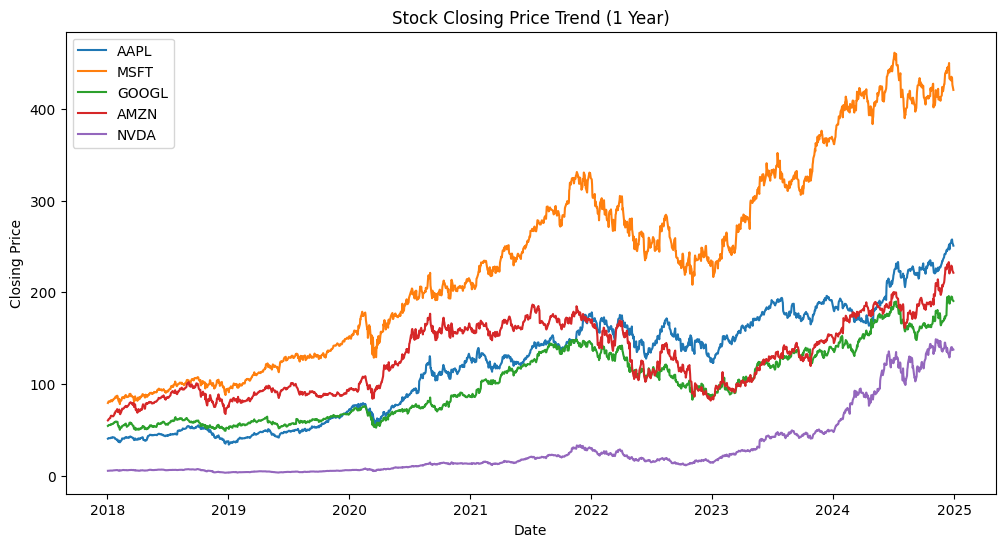

In [17]:
# Closing Price Trend (Time Series)

plt.figure(figsize=(12, 6))

for sym in symbols:
    plt.plot(data[sym].index, data[sym]["Close"], label=sym)

plt.title("Stock Closing Price Trend (1 Year)")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend()
plt.show()

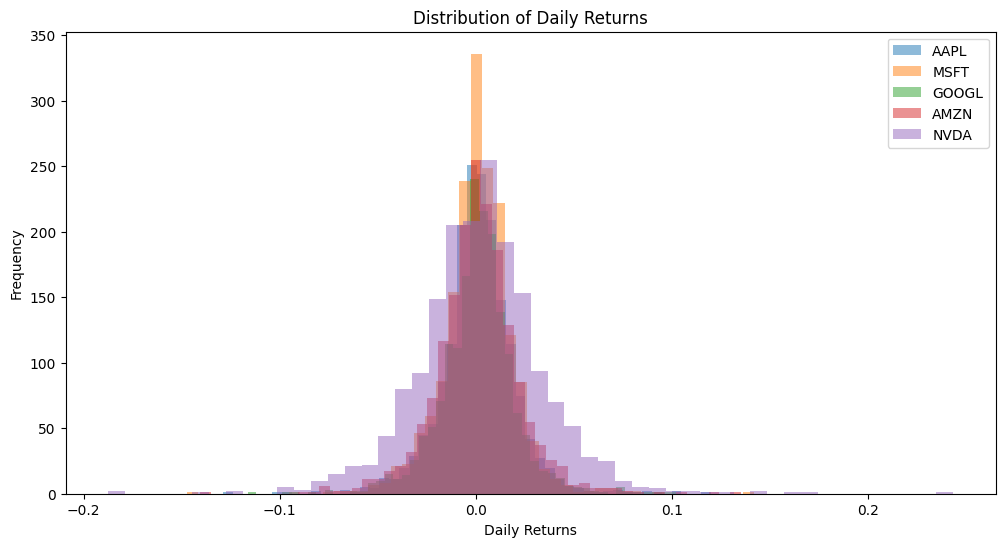

In [18]:
# Daily Returns Distribution (Risk Visualization)

plt.figure(figsize=(12, 6))

for sym in symbols:
    returns = data[sym]["Close"].pct_change()
    plt.hist(returns.dropna(), bins=50, alpha=0.5, label=sym)

plt.title("Distribution of Daily Returns")
plt.xlabel("Daily Returns")
plt.ylabel("Frequency")
plt.legend()
plt.show()

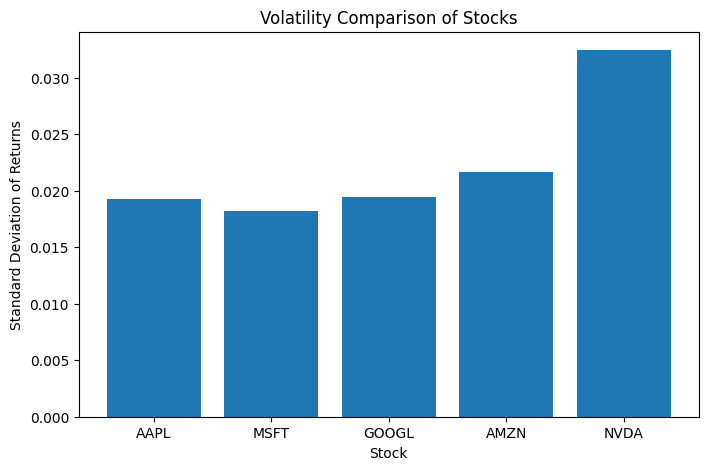

In [19]:
# Volatility Comparison (Bar Chart)

volatility = []

for sym in symbols:
    vol = data[sym]["Close"].pct_change().dropna().std()
    volatility.append(float(vol))

vol_df = pd.DataFrame({
    "Stock": symbols,
    "Volatility": volatility
})

plt.figure(figsize=(8, 5))
plt.bar(vol_df["Stock"].values, vol_df["Volatility"].values)
plt.title("Volatility Comparison of Stocks")
plt.xlabel("Stock")
plt.ylabel("Standard Deviation of Returns")
plt.show()

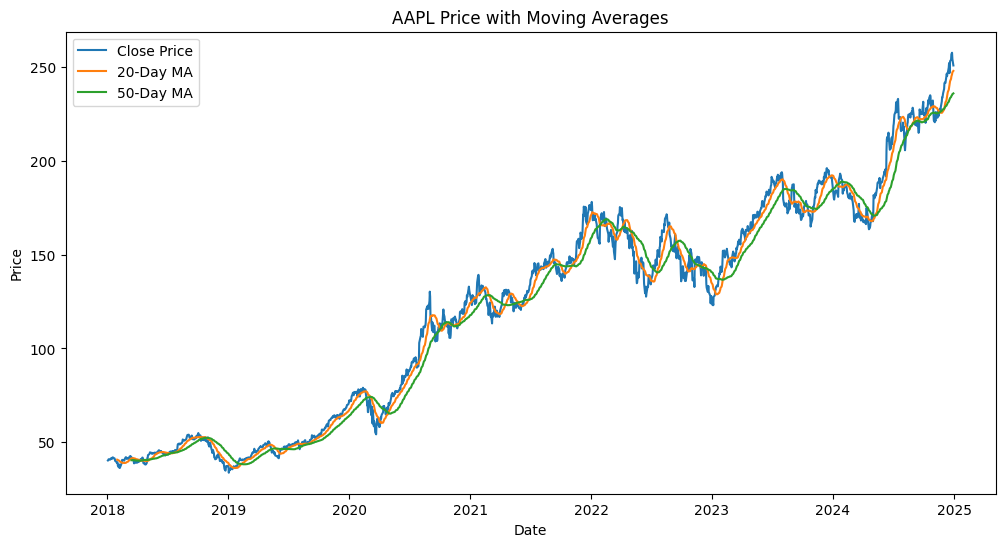

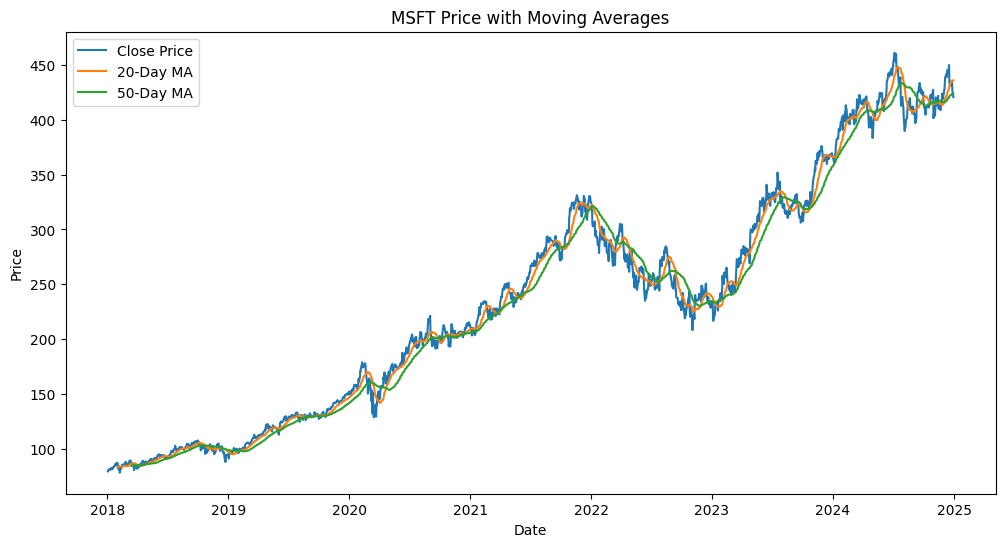

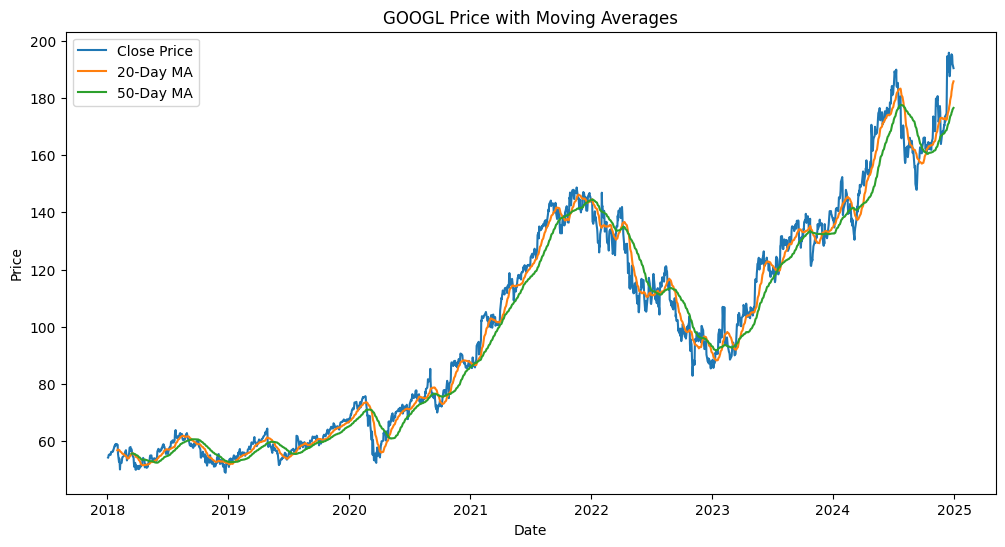

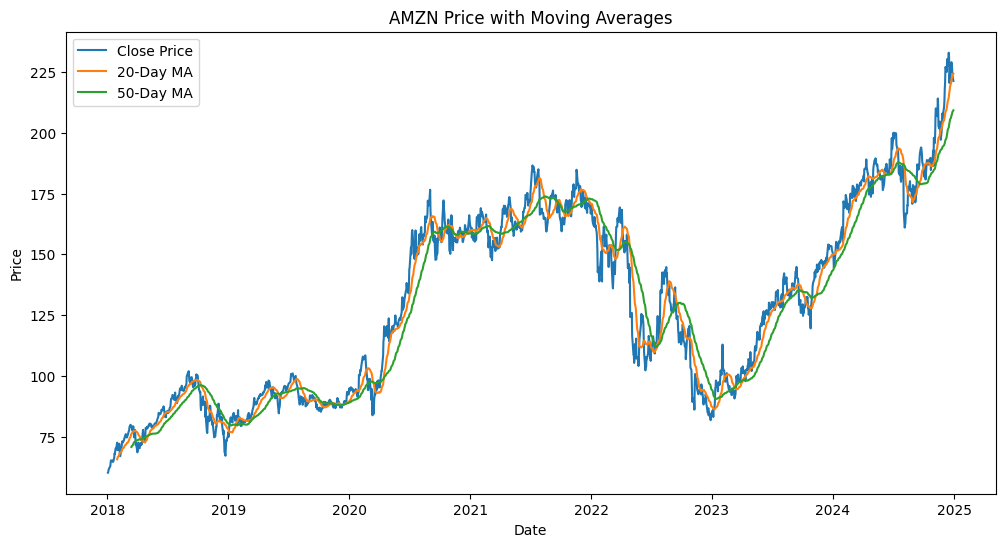

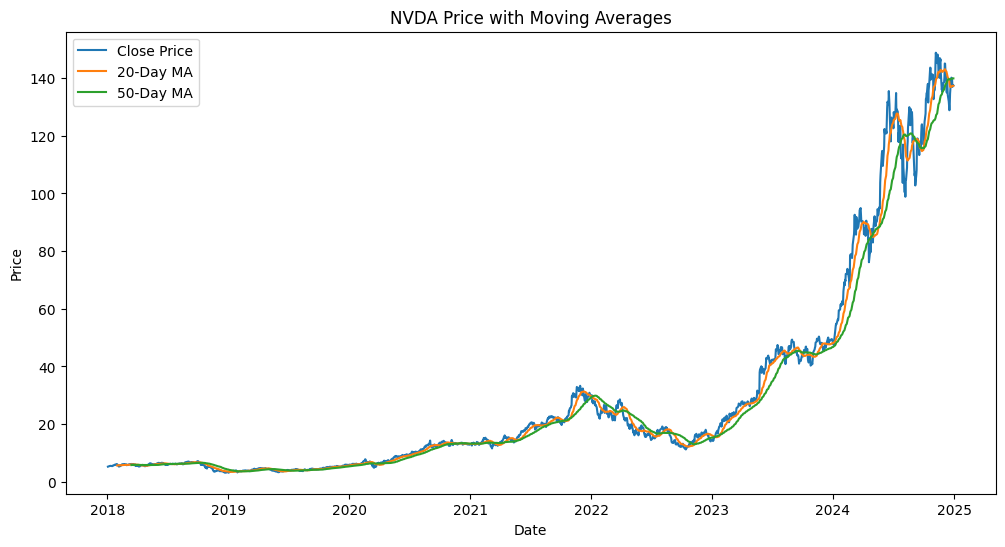

In [20]:
# Moving Averages (Trend Strength)

window_short = 20
window_long = 50

for sym in symbols:
    df = data[sym].copy()
    df["MA20"] = df["Close"].rolling(window_short).mean()
    df["MA50"] = df["Close"].rolling(window_long).mean()

    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df["Close"], label="Close Price")
    plt.plot(df.index, df["MA20"], label="20-Day MA")
    plt.plot(df.index, df["MA50"], label="50-Day MA")
    plt.title(f"{sym} Price with Moving Averages")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

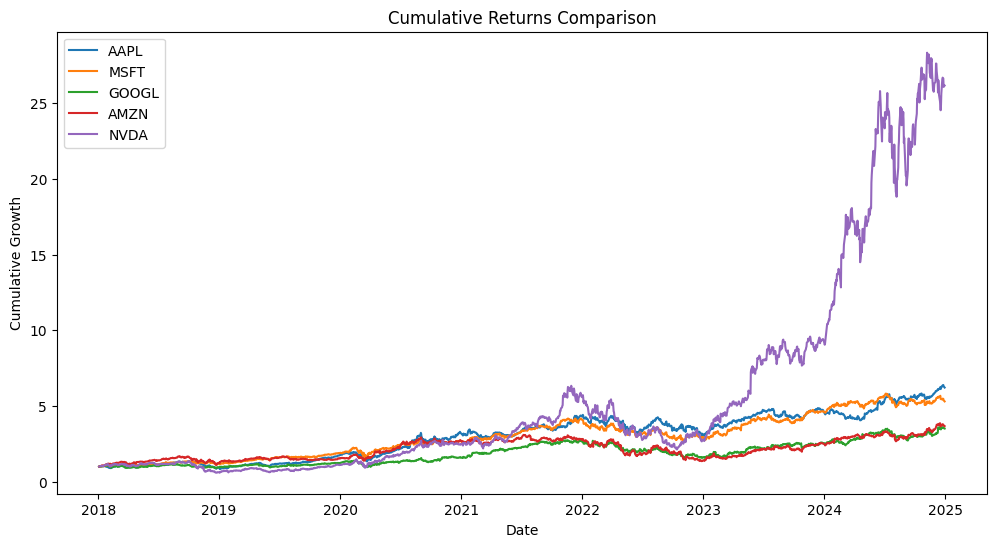

In [21]:
# Cumulative Returns (Performance Comparison)

plt.figure(figsize=(12, 6))

for sym in symbols:
    returns = data[sym]["Close"].pct_change()
    cumulative_returns = (1 + returns).cumprod()
    plt.plot(cumulative_returns, label=sym)

plt.title("Cumulative Returns Comparison")
plt.xlabel("Date")
plt.ylabel("Cumulative Growth")
plt.legend()
plt.show()

<Figure size 800x400 with 0 Axes>

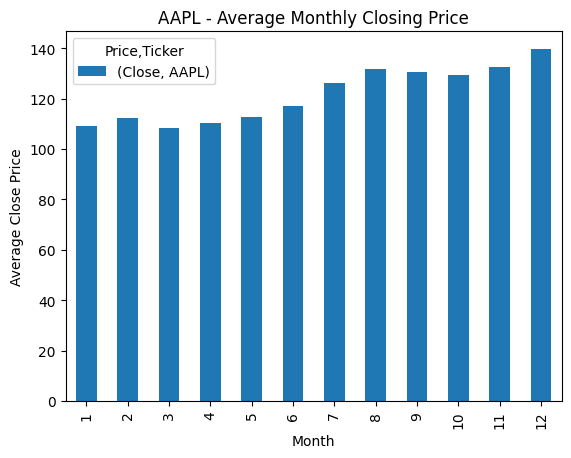

<Figure size 800x400 with 0 Axes>

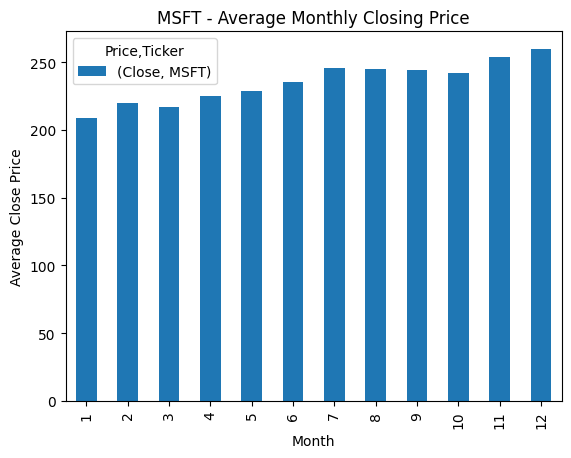

<Figure size 800x400 with 0 Axes>

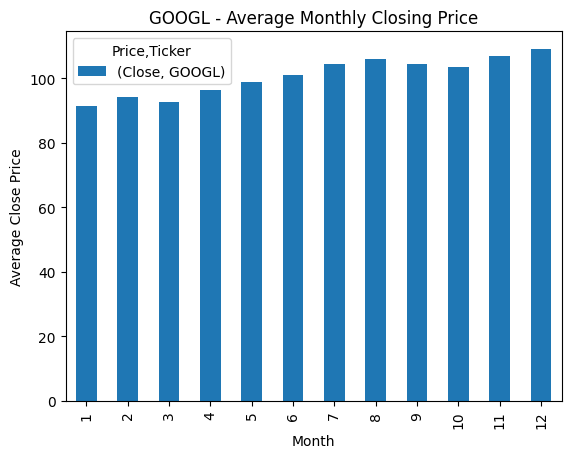

<Figure size 800x400 with 0 Axes>

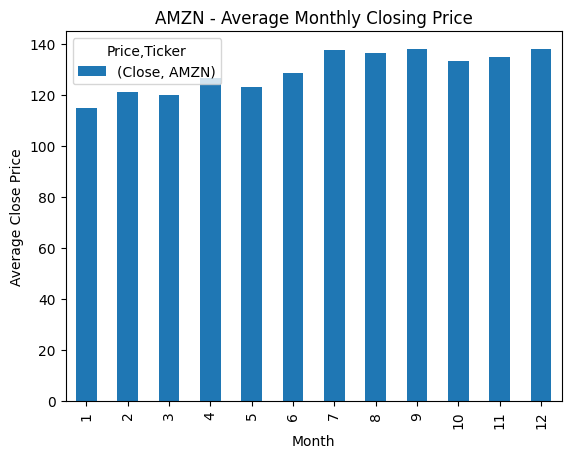

<Figure size 800x400 with 0 Axes>

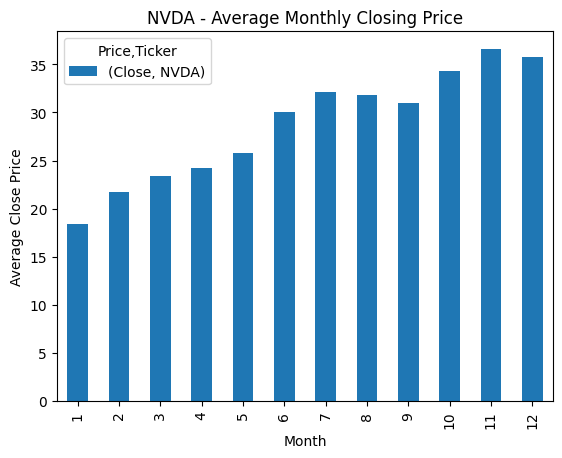

In [22]:
for sym in symbols:
    df = data[sym].copy()

    # Ensure datetime index
    df.index = pd.to_datetime(df.index)

    # Create Month column
    df["Month"] = df.index.month

    # Monthly average closing price
    monthly_avg = df.groupby("Month")["Close"].mean()

    plt.figure(figsize=(8,4))
    monthly_avg.plot(kind="bar")
    plt.title(f"{sym} - Average Monthly Closing Price")
    plt.ylabel("Average Close Price")
    plt.show()

In [25]:
# Feature Engineering for Deep Learning
import numpy as np
df = data["AAPL"].copy()

# Log returns
df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))

# Rolling volatility
df["volatility_20"] = df["log_return"].rolling(20).std()

# Momentum
df["momentum_10"] = df["Close"] - df["Close"].shift(10)

df = df.dropna()

# Data Scaling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(df[["Close"]])

In [26]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense

from statsmodels.tsa.arima.model import ARIMA

In [27]:
def create_sequences(series, window_size=60):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

def evaluate(true, pred):
    mae = mean_absolute_error(true, pred)
    rmse = math.sqrt(mean_squared_error(true, pred))
    mape = np.mean(np.abs((true - pred) / true)) * 100
    return mae, rmse, mape

In [28]:
window_size = 60

for sym in symbols:
    print(f"\n===== {sym} Deep Learning Models =====")

    df = data[sym]
    prices = df["Close"].values.reshape(-1, 1)

    # Scale
    scaler = MinMaxScaler()
    scaled_prices = scaler.fit_transform(prices)

    # Create sequences
    X, y = create_sequences(scaled_prices, window_size)

    # Time-series split (NO SHUFFLE)
    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # ---------------- LSTM ----------------
    lstm_model = Sequential([
        LSTM(50, input_shape=(window_size, 1)),
        Dense(1)
    ])

    lstm_model.compile(optimizer="adam", loss="mse")
    lstm_model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)

    lstm_pred_scaled = lstm_model.predict(X_test)
    lstm_pred = scaler.inverse_transform(lstm_pred_scaled)
    y_test_actual = scaler.inverse_transform(y_test)

    lstm_mae, lstm_rmse, lstm_mape = evaluate(y_test_actual, lstm_pred)

    print("LSTM Results:")
    print(f"MAE  : {lstm_mae:.3f}")
    print(f"RMSE : {lstm_rmse:.3f}")
    print(f"MAPE : {lstm_mape:.2f}%")

    # ---------------- GRU ----------------
    gru_model = Sequential([
        GRU(50, input_shape=(window_size, 1)),
        Dense(1)
    ])

    gru_model.compile(optimizer="adam", loss="mse")
    gru_model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)

    gru_pred_scaled = gru_model.predict(X_test)
    gru_pred = scaler.inverse_transform(gru_pred_scaled)

    gru_mae, gru_rmse, gru_mape = evaluate(y_test_actual, gru_pred)

    print("\nGRU Results:")
    print(f"MAE  : {gru_mae:.3f}")
    print(f"RMSE : {gru_rmse:.3f}")
    print(f"MAPE : {gru_mape:.2f}%")


===== AAPL Deep Learning Models =====
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
LSTM Results:
MAE  : 4.757
RMSE : 5.987
MAPE : 2.36%
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

GRU Results:
MAE  : 3.218
RMSE : 4.032
MAPE : 1.61%

===== MSFT Deep Learning Models =====
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
LSTM Results:
MAE  : 8.526
RMSE : 10.535
MAPE : 2.15%
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step

GRU Results:
MAE  : 5.932
RMSE : 7.766
MAPE : 1.50%

===== GOOGL Deep Learning Models =====
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
LSTM Results:
MAE  : 4.309
RMSE : 5.558
MAPE : 2.76%
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step

GRU Results:
MAE  : 2.840
RMSE : 3.781
MAPE : 1.84%

===== AMZN Deep Learning Models =====
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
LSTM Results:
MAE  : 4.702
RMSE : 5.942
MAPE : 2.74%
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

GRU Results:
MAE  : 3.309
RMSE : 4.261
MAPE : 1.94%

===== NVDA Deep Learning Models =====
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
LSTM Results:
MAE  

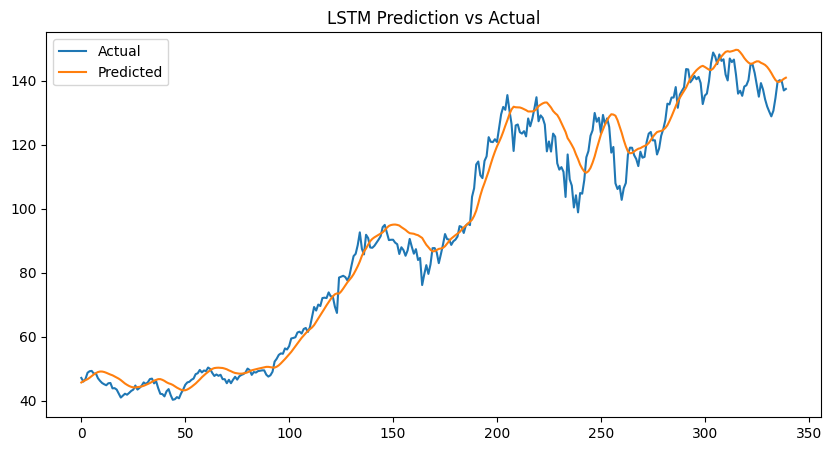

In [29]:
plt.figure(figsize=(10,5))
plt.plot(y_test_actual, label="Actual")
plt.plot(lstm_pred, label="Predicted")
plt.legend()
plt.title("LSTM Prediction vs Actual")
plt.show()

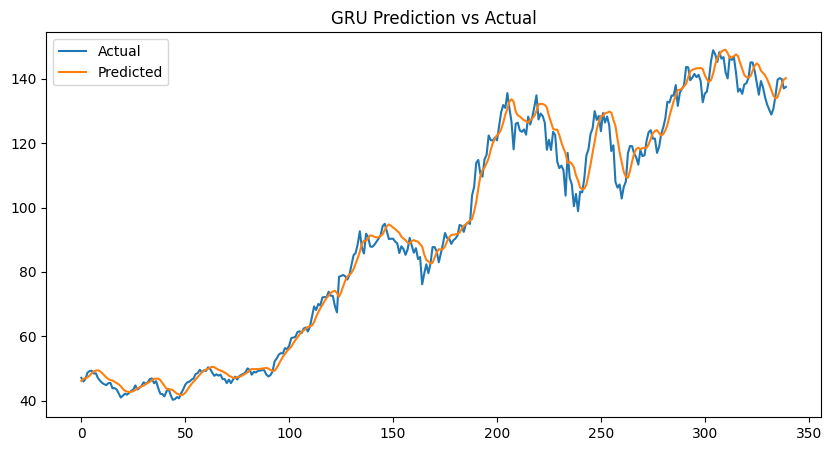

In [30]:
plt.figure(figsize=(10,5))
plt.plot(y_test_actual, label="Actual")
plt.plot(gru_pred, label="Predicted")
plt.legend()
plt.title("GRU Prediction vs Actual")
plt.show()

In [31]:
for sym in symbols:
    print(f"\n===== {sym} ARIMA Model =====")

    df = data[sym]
    prices = df["Close"].values

    split = int(len(prices) * 0.8)
    train, test = prices[:split], prices[split:]

    model = ARIMA(train, order=(5, 1, 0))
    fitted = model.fit()

    forecast = fitted.forecast(steps=len(test))

    arima_mae, arima_rmse, arima_mape = evaluate(test, forecast)

    print("ARIMA Results:")
    print(f"MAE  : {arima_mae:.3f}")
    print(f"RMSE : {arima_rmse:.3f}")
    print(f"MAPE : {arima_mape:.2f}%")


===== AAPL ARIMA Model =====
ARIMA Results:
MAE  : 24.322
RMSE : 32.751
MAPE : 11.17%

===== MSFT ARIMA Model =====
ARIMA Results:
MAE  : 71.506
RMSE : 80.623
MAPE : 17.37%

===== GOOGL ARIMA Model =====
ARIMA Results:
MAE  : 24.261
RMSE : 30.370
MAPE : 14.55%

===== AMZN ARIMA Model =====
ARIMA Results:
MAE  : 32.549
RMSE : 39.102
MAPE : 17.61%

===== NVDA ARIMA Model =====
ARIMA Results:
MAE  : 45.179
RMSE : 57.410
MAPE : 40.36%


In [32]:
results = pd.DataFrame({
    "Model": ["LSTM", "GRU", "ARIMA"],
    "MAE": [lstm_mae, gru_mae, arima_mae],
    "RMSE": [lstm_rmse, gru_rmse, arima_rmse],
    "MAPE": [lstm_mape, gru_mape, arima_mape]
})

print(results)

   Model        MAE       RMSE       MAPE
0   LSTM   4.484636   6.152180   4.936234
1    GRU   3.159549   4.340587   3.413625
2  ARIMA  45.179238  57.409514  40.358831
